In [1]:
# Calculations of accretion rates for Bondi-Hoyle-Lyttleton (BHL) 
# accretion model used in reference papaer M. Ricotti et al. 
# https://arxiv.org/abs/0709.0524 and Park Ricotti Model (PR)
# accretion model as per F. Scarcella et al. 2020, 
# https://arxiv.org/abs/2012.10421 . 


# Here, the value of the speed of sound in the ioinized region of 
# PR Model is chosen as c_s,in = 25 c_s. c_s,in is the free parameter 
# of PR accretion Model.


# The values of v_pbh, c_s and v_eff are used as per 
# M. Ricotti et al. 2007 https://arxiv.org/abs/0709.0524
 

# Here, v_eff = v_eff,A as mentioned in
# M. Ricotti et al. 2007 https://arxiv.org/abs/0709.0524



from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from PRaccretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


def c_s(z):
    return c_s_Ricotti(z)

def v_pbh(z):
    return v_rel_digitized_Ricotti(z)

def v_eff(z):
    return v_eff_Ricotti(z)

def x_e(z):
    if z < z_rec:
        return e_fraction
    else:
        return 1
    


    
    
# BHL accretion Model around isolated PBHs 
def r_B_pbh(z, m):
    return (G * m)/(v_eff(z)**2)

def β_cap_pbh(z, m):
    return 1e-4 * m * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_pbh(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_pbh(z, m)))/β_cap_pbh(z, m) 
    return np.exp((9/2)/(3 + β_cap_pbh(z, m)**(0.75))) * (x_cr(z, m)**2)

def M_dot_BHL(z, m):
    return 4 * np.pi * λ_pbh(z, m) *  ρ(z) * v_eff(z) * (r_B_pbh(z, m)**2)

def M_dot_BHL_by_dz(z, m):
    return M_dot_BHL(z, m) * (dt_dz(z))

def m_dot_BHL(z, m):
    return M_dot_BHL(z, m)/M_dot_Edd(z, m) 





# BHL accretion Model in the presence of DM halos around isolated PBHs  
def r_h(z, m):
    if DM_densityprofile94 == True:
        return r_ta94(z, m)
    else:
        return r_ta32(z, m)

    



def M_halo_total(z, m): # Mass of the DM halo at turn around radius r_ta.
    if DM_densityprofile94 == True:
        return M_halo94(z, m)
    else:
        return M_halo32(z, m)



    
def r_B_halo(z, m):
    return (G * M_halo_total(z, m))/(v_eff(z)**2)


def r_B_eff(z, m):
    r_B_pbh_var = r_B_pbh(z, m)
    if r_h(z, m) <= r_B_halo(z, m):
        r_B_eff_var = r_B_halo(z, m)
    else:
        r_B_eff_var = r_h(z, m) * (((1-p) * (r_h(z, m)/r_B_halo(z, m)) + p)**(1/(p-1)))
    if r_B_eff_var < r_B_pbh_var:
         return r_B_pbh_var
    else:
         return r_B_eff_var
      
        

def β_cap_pbh_halo(z, m):
    return 1e-4 * (m + M_halo_total(z, m)) * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_pbh_halo(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_pbh_halo(z, m)))/β_cap_pbh_halo(z, m) 
    return np.exp((9/2)/(3 + β_cap_pbh_halo(z, m)**(0.75))) * (x_cr(z, m)**2)


def M_dot_BHL_halo(z, m):
    return 4 * np.pi * λ_pbh_halo(z, m) * ρ(z) * v_eff(z) * (r_B_eff(z, m)**(2))

def M_dot_BHL_by_dz_halo(z, m):
    return M_dot_BHL_halo(z, m) * (dt_dz(z))

def m_dot_BHL_halo(z, m):
    return M_dot_BHL_halo(z, m)/M_dot_Edd(z, m) 






# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.
# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.

free_parameter = 25
def c_s_in(z):
    return free_parameter * c_s(z)
def v_R(z):
    return  2 * c_s_in(z)
def v_D(z):
    return  (c_s(z)**2)/(2 * c_s_in(z))
def Δ(z):
    return (((v_pbh(z)**2) + (c_s(z)**2))**2) - (4 * (v_pbh(z)**2) * (c_s_in(z)**2)) 
def ρ_in_plus(z):
    return  ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) + np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_minus(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) - np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_0(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2))/(2 * (c_s_in(z)**2)))
def ρ_in(z):
    if v_pbh(z) <= v_D(z):
        return ρ_in_plus(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return ρ_in_0(z)
    else:
        return ρ_in_minus(z)

def v_in(z):
    if v_pbh(z) <= v_D(z):
        return (ρ(z)/ρ_in(z)) * v_pbh(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return c_s_in(z)
    else:
        return (ρ(z)/ρ_in(z)) * v_pbh(z)
    

def v_eff_in(z):
    return np.sqrt((v_in(z)**2) + (c_s_in(z)**2))

def r_B_in(z, m):
    return (G * m)/(v_eff_in(z)**2)

        
def M_dot_PR(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_in(z, m)**2)

def M_dot_PR_by_dz(z, m):
    return M_dot_PR(z, m) * (dt_dz(z))

def m_dot_PR(z, m):
    return (M_dot_PR(z, m)/M_dot_Edd(z, m))




def r_B_eff_in(z, m):
    def r_B_pbh_in(z, m):
        return (G * m)/(v_eff_in(z)**2)
    def r_B_halo_in(z, m):
        return (G * M_halo_total(z, m))/(v_eff_in(z)**2)
    if r_h(z, m) <= r_B_halo_in(z, m):
        r_B_eff_in_var = r_B_halo_in(z, m)
    else:
        r_B_eff_in_var = r_h(z, m) * (((1-p) * (r_h(z, m)/r_B_halo_in(z, m)) + p)**(1/(p-1)))
    if r_B_eff_in_var < r_B_pbh_in(z, m):
         return r_B_pbh_in(z, m)
    else:
         return r_B_eff_in_var
        
        
def M_dot_PR_halo(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_eff_in(z, m)**2)

def M_dot_PR_by_dz_halo(z, m):
    return M_dot_PR_halo(z, m) * (dt_dz(z))

def m_dot_PR_halo(z, m):
    return (M_dot_PR_halo(z, m)/M_dot_Edd(z, m))

In [2]:
# Calculations of the accretion parameters and accretion rate 
# as per the DM density profile of ρ(r) ∝ r^{-3/2}.

DM_densityprofile94 = False
alpha = 3/2
p = 3 - alpha 

free_parameter = 25

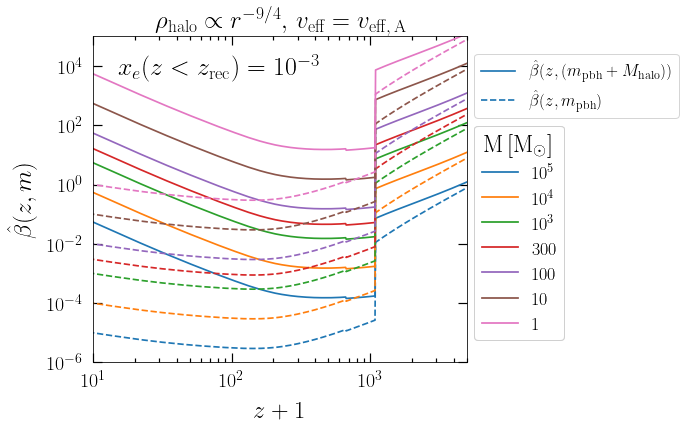

In [3]:
# When the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.

colors = ['C0', 'C1','C2','C3','C4', 'C5', 'C6']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1, 10, 100, 300, 1e3, 1e4, 1e5])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_pbh_halo_array = np.zeros(len(z_array))

e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_pbh_halo_array[i] = β_cap_pbh_halo(z, m)
    ax.loglog(z_array, β_pbh_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta(z, (m_\mathrm{pbh} + M_\mathrm{halo}))$", r"$\hat \beta(z, m_\mathrm{pbh})$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-6, 1e5)
plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1e-3_halo32.pdf', bbox_inches = 'tight')
plt.show()

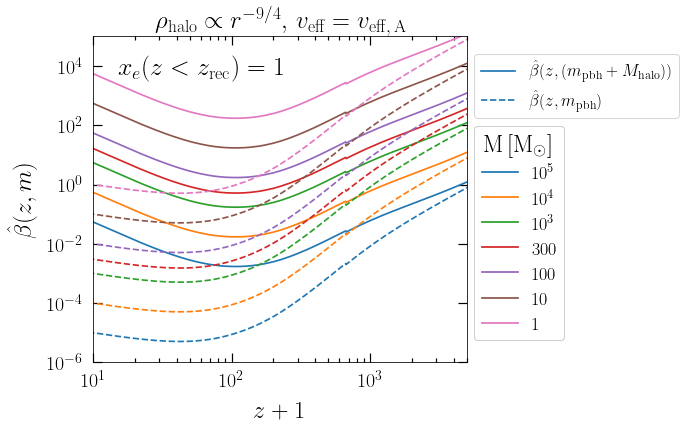

In [4]:
# When the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1.

colors = ['C0', 'C1','C2','C3','C4', 'C5', 'C6']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1, 10, 100, 300, 1e3, 1e4, 1e5])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_pbh_halo_array = np.zeros(len(z_array))

e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_pbh_halo_array[i] = β_cap_pbh_halo(z, m)
    ax.loglog(z_array, β_pbh_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta(z, (m_\mathrm{pbh} + M_\mathrm{halo}))$", r"$\hat \beta(z, m_\mathrm{pbh})$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-6, 1e5)
plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1_halo32.pdf', bbox_inches = 'tight')
plt.show()

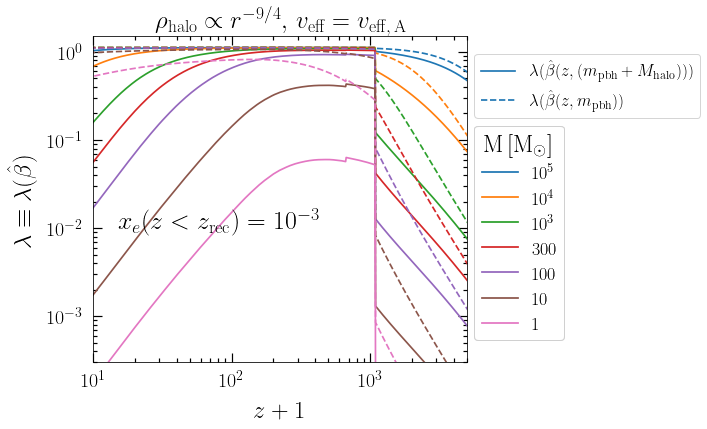

In [5]:
# When the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.

colors = ['C0', 'C1','C2','C3','C4', 'C5', 'C6']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1, 10, 100, 300, 1e3, 1e4, 1e5])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_pbh_halo_array = np.zeros(len(z_array))

e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_pbh_halo_array[i] = λ_pbh_halo(z, m)
    ax.loglog(z_array, λ_pbh_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(10, 5000)
plt.ylim(3e-4, 1.5)
plt.text(15, 1e-2, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\lambda \equiv \lambda(\hat \beta)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda(\hat \beta(z, (m_\mathrm{pbh} + M_\mathrm{halo})))$", r"$\lambda(\hat \beta(z, m_\mathrm{pbh}))$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('λvsz_xe1e-3_halo32.pdf', bbox_inches = 'tight')
plt.show()

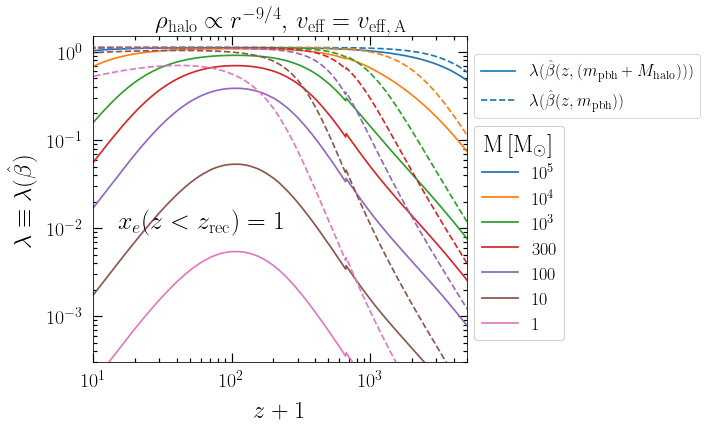

In [6]:
# When the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1.

colors = ['C0', 'C1','C2','C3','C4', 'C5', 'C6']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1, 10, 100, 300, 1e3, 1e4, 1e5])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_pbh_halo_array = np.zeros(len(z_array))

e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_pbh_halo_array[i] = λ_pbh_halo(z, m)
    ax.loglog(z_array, λ_pbh_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(10, 5000)
plt.ylim(3e-4, 1.5)
plt.text(15, 1e-2, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\lambda \equiv \lambda(\hat \beta)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda(\hat \beta(z, (m_\mathrm{pbh} + M_\mathrm{halo})))$", r"$\lambda(\hat \beta(z, m_\mathrm{pbh}))$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('λvsz_xe1_halo32.pdf', bbox_inches = 'tight')
plt.show()

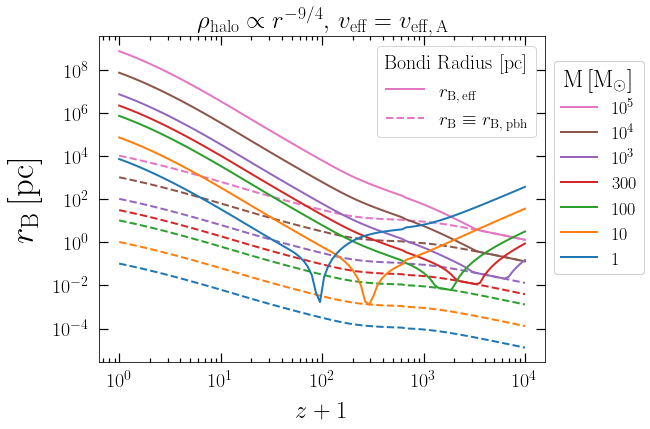

In [7]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1, 1e4, 100)


r_B_pbh_arr = np.zeros(len(z_arr))
r_B_eff_arr = np.zeros(len(z_arr))




for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for j, z in enumerate(z_arr):
        r_B_pbh_arr[j] = r_B_pbh(z, m)
        r_B_eff_arr[j] = r_B_eff(z, m)
    ax.loglog(z_arr, r_B_eff_arr, color = color)
    ax.loglog(z_arr, r_B_pbh_arr, color = color, ls = '--')
    

    

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["$r_\mathrm{B, \,eff}$","$r_\mathrm{B}\equiv r_\mathrm{B, \,pbh}$"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 20, loc = 'upper right', prop = {"size":19})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.27), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.xlabel('$z+1$', fontsize = 24.5, labelpad = 10)
plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 35, labelpad = 11)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('r_B_BHL_eff32.pdf', bbox_inches = 'tight')
plt.show()


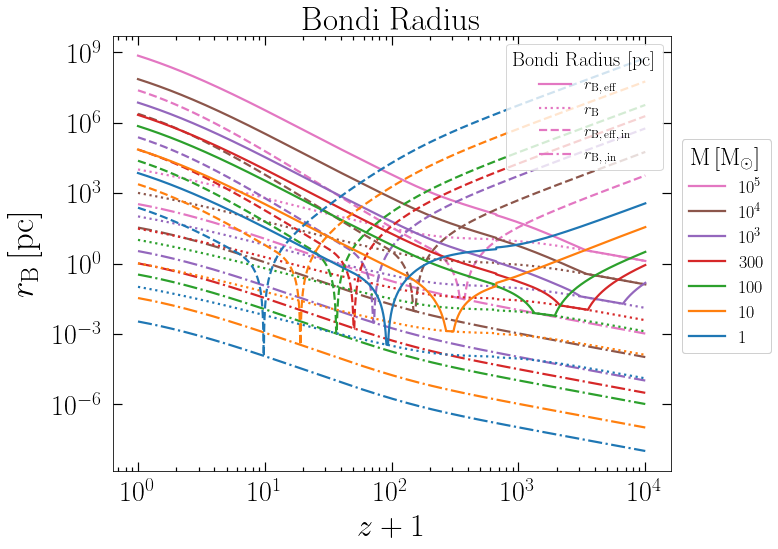

In [8]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (10, 8))
plt.rc('lines', linewidth = 2.2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')

mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1, 1e4, 10000)
r_B_array = np.zeros(len(z_array))
r_B_in_array = np.zeros(len(z_array))
r_B_eff_array = np.zeros(len(z_array))
r_B_eff_in_array = np.zeros(len(z_array))



for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        r_B_array[i] = r_B_pbh(z, m) 
        r_B_in_array[i] = r_B_in(z, m)
        r_B_eff_array[i] = r_B_eff(z, m)
        r_B_eff_in_array[i] = r_B_eff_in(z, m)
        
    ax.loglog(z_array, r_B_eff_array, color = color)
    ax.loglog(z_array, r_B_array, color = color, ls = 'dotted')
    ax.loglog(z_array, r_B_eff_in_array, color = color, ls = '--')
    ax.loglog(z_array, r_B_in_array, color = color, ls = '-.')

    
    



ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2, 3]], ["$r_\mathrm{B, \,eff}$", "$r_\mathrm{B}$", "$r_\mathrm{B, \,eff, \,in}$", "$r_\mathrm{B, \,, in}$"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 20, loc = 'upper right', prop = {"size":16})
legend2 = plt.legend([lines[i] for i in [0, 4, 8, 12, 16, 20, 24]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.27), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)




plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 35, labelpad = 11)
plt.xlabel(r"$z + 1$", fontsize = 32, labelpad = 8)
plt.xticks(fontsize = 28)
plt.yticks(fontsize = 28)
plt.title('Bondi Radius', fontsize = 33, pad = 6)
plt.savefig('r_B_total32.pdf', bbox_inches = 'tight')
plt.show()

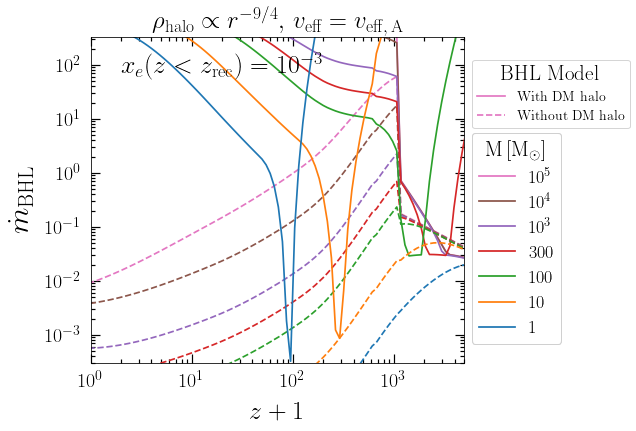

In [9]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))



e_fraction = 1e-3

for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_arr[i] = m_dot_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_BHL_halo(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_arr, color = color, ls = '--')
    

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{BHL} $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(3e-4, 330)
plt.xlim(1, 5000)
plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_BHL_xe1e-3_32.pdf', bbox_inches = 'tight')
plt.show()

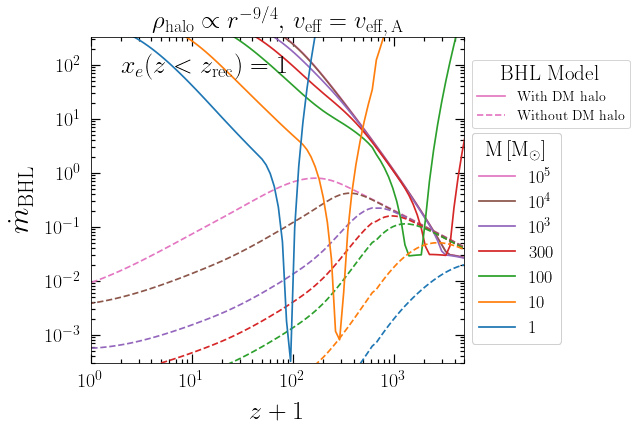

In [10]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))

e_fraction = 1



for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_arr[i] = m_dot_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_BHL_halo(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_arr, color = color, ls = '--')
    

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{BHL} $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(3e-4, 330)
plt.xlim(1, 5000)
plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_BHL_xe1_32.pdf', bbox_inches = 'tight')
plt.show()

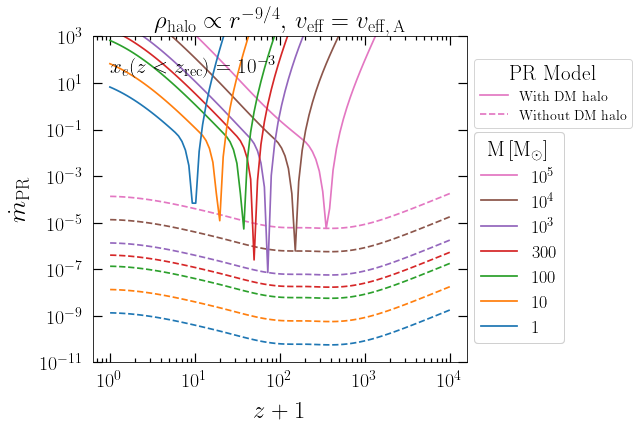

In [11]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_PR_halo_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_PR_halo_arr[i] = m_dot_PR_halo(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_PR_halo_arr, color = color)
    plt.loglog(z_array, m_dot_PR_arr, color = color, ls = '--')
    
plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{PR}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'PR Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_PR_xe1e-3_32.pdf', bbox_inches = 'tight')
plt.show()

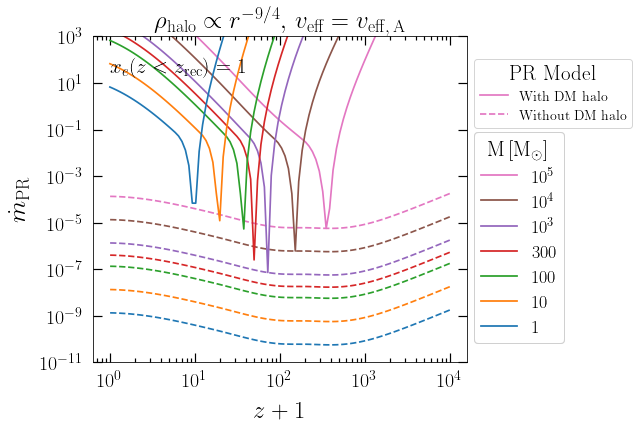

In [12]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_PR_halo_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))



e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_PR_halo_arr[i] = m_dot_PR_halo(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_PR_halo_arr, color = color)
    plt.loglog(z_array, m_dot_PR_arr, color = color, ls = '--')
    
plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{PR}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'PR Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_PR_xe1_32.pdf', bbox_inches = 'tight')
plt.show()

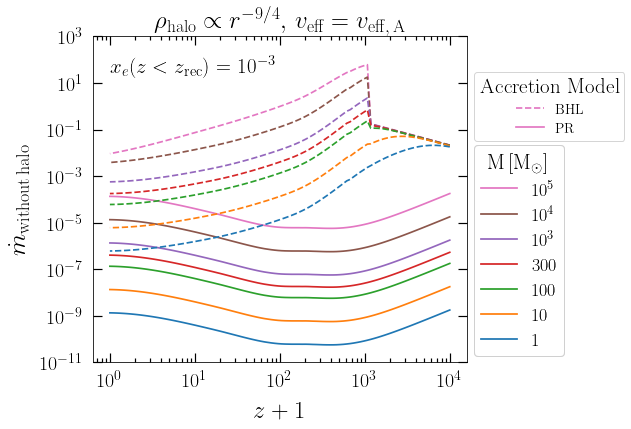

In [13]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_arr[i] = m_dot_BHL(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_arr, color = color)
    
plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{without \, halo}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dotBHLPR_xe1e-3_32.pdf', bbox_inches = 'tight')
plt.show()

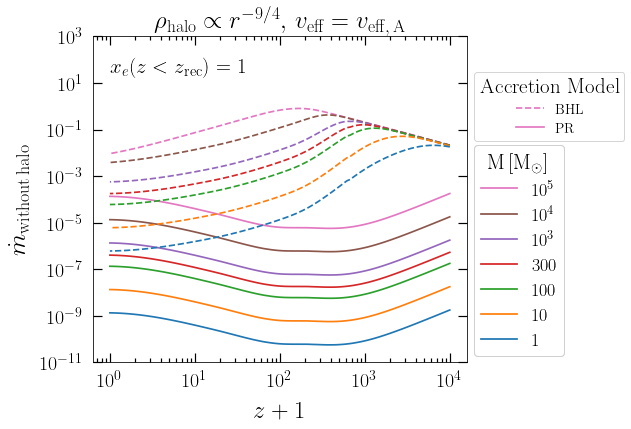

In [14]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_arr = np.zeros(len(z_array))
m_dot_PR_arr = np.zeros(len(z_array))

e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_arr[i] = m_dot_BHL(z, m)
        m_dot_PR_arr[i] = m_dot_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_arr, color = color)
    
plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{without \, halo}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_dotBHLPR_xe1_32.pdf', bbox_inches = 'tight')
plt.show()

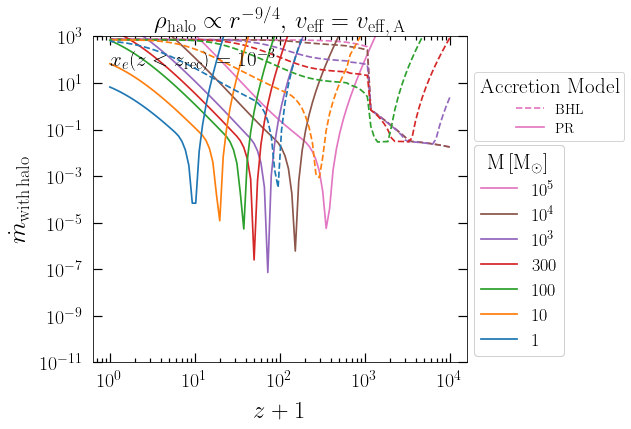

In [15]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_halo_arr = np.zeros(len(z_array))
m_dot_PR_halo_arr = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_halo_arr[i] = m_dot_BHL_halo(z, m)
        m_dot_PR_halo_arr[i] = m_dot_PR_halo(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_halo_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_halo_arr, color = color)
    
plt.text(1, 60, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{with \, halo}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_doth_BHLPR_halo_xe1e-3_32.pdf', bbox_inches = 'tight')
plt.show()

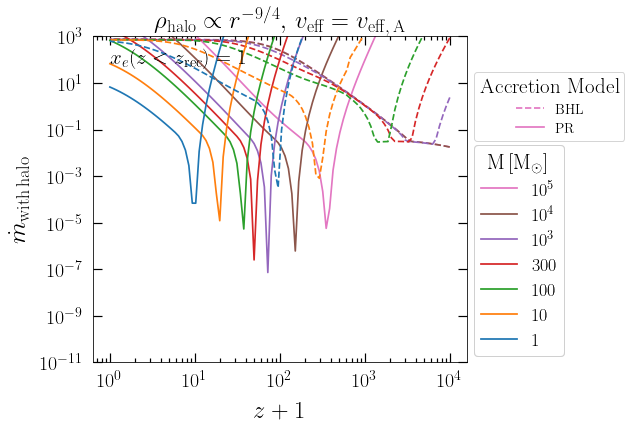

In [16]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_BHL_halo_arr = np.zeros(len(z_array))
m_dot_PR_halo_arr = np.zeros(len(z_array))


e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_BHL_halo_arr[i] = m_dot_BHL_halo(z, m)
        m_dot_PR_halo_arr[i] = m_dot_PR_halo(z, m)
    
    
    plt.loglog(z_array, m_dot_BHL_halo_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_PR_halo_arr, color = color)
    
plt.text(1, 70, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 21)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(' $\dot m_\mathrm{with \, halo}$', fontsize = 26, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)

plt.title(r'$\rho_\mathrm{halo} \propto r^{-9/4}, \, v_\mathrm{eff} = v_\mathrm{eff,\, A}$', fontsize = 25, pad = 8)
plt.savefig('m_doth_BHLPR_halo_xe1_32.pdf', bbox_inches = 'tight')
plt.show()